In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from refcm import RefCM
from matchings import Matching

import config
import logging

config.start_logging(logging.DEBUG)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
alm = sc.read_h5ad('data/ALM.h5ad')
visp = sc.read_h5ad('data/VISP.h5ad')
mtg = sc.read_h5ad('data/MTG.h5ad')

[h5py._conv      ] [DEBUG   ] : Creating converter from 3 to 5


In [4]:
ds = {'MTG': mtg, 'ALM': alm, 'VISp': visp}
trials = [
    ('MTG', 'ALM'),
    ('MTG', 'VISp'),
    ('ALM', 'MTG'),
    ('ALM', 'VISp'),
    ('VISp', 'MTG'),
    ('VISp', 'ALM'),
]

In [9]:
rcm = RefCM()
m = rcm.annotate(mtg, 'MTG', alm, "ALM", 'labels34', 'labels34')
m.eval('labels34')
m.display_matching_costs(ground_truth_obs_key='labels34')

[refcm           ] [INFO    ] : NOTE: raw counts expected in anndata .X attributes.
[refcm           ] [DEBUG   ] : No existing matching db cost file db.json found.


[refcm           ] [DEBUG   ] : Selecting joint gene subset for query and reference datasets
/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

[refcm           ] [DEBUG   ] : Using 1934 genes.
[refcm           ] [DEBUG   ] : Computing Wasserstein distances.
|████████████████| [100.00% ] : 00:42
[refcm           ] [DEBUG   ] : starting LP op

/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

... storing 'labels3' as categorical
... storing 'labels34' as categorical
... storing 'refcm_annot' as categorical
/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



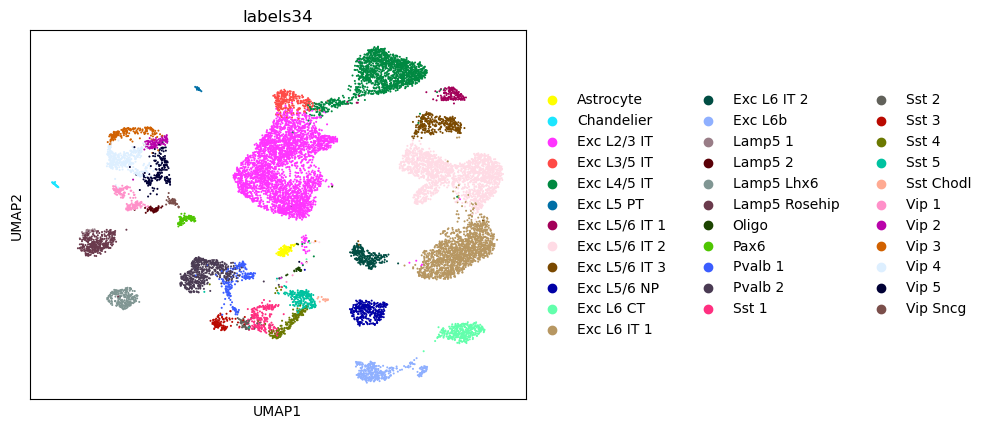

In [7]:
sc.tl.pca(mtg)
sc.pp.neighbors(mtg)
sc.tl.umap(mtg)
sc.pl.umap(mtg, color='labels34')

... storing 'labels3' as categorical
... storing 'labels34' as categorical
/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



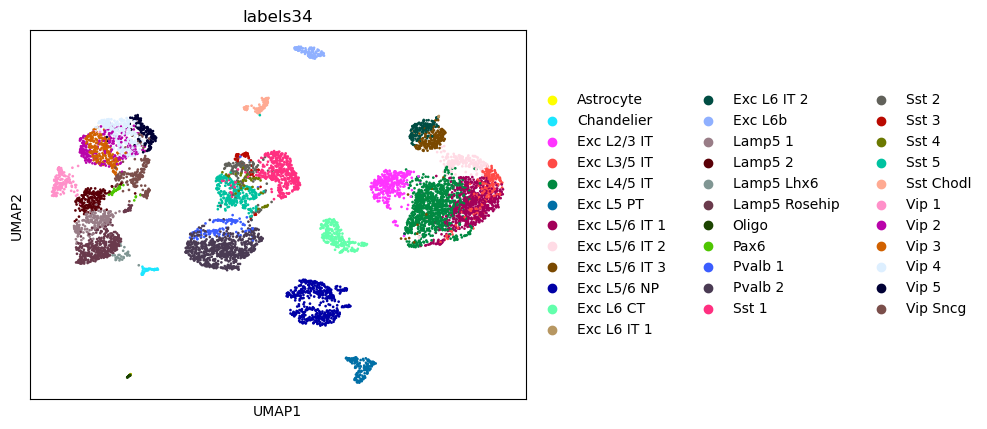

In [8]:
sc.tl.pca(alm)
sc.pp.neighbors(alm)
sc.tl.umap(alm)
sc.pl.umap(alm, color='labels34')

In [15]:
rcm = RefCM()

for query, ref in trials:

    rcm.annotate(ds[query], query, ds[ref], ref, 'labels34', 'labels34')
    m = Matching(ds[query], ds[ref], query, ref)
    m.eval('labels34')

[refcm           ] [INFO    ] : NOTE: raw counts expected in anndata .X attributes.
[refcm           ] [DEBUG   ] : No existing matching db cost file db.json found.


[refcm           ] [DEBUG   ] : Selecting joint gene subset for query and reference datasets
/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/homebrew/anaconda3/envs/RefCM/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

[refcm           ] [DEBUG   ] : Using 1973 genes.
[refcm           ] [DEBUG   ] : Computing Wasserstein distances.
|████████████████| [100.00% ] : 00:34
[refcm           ] [DEBUG   ] : starting LP op

# Cluster splitting/merging

In [8]:
def analyse_hierarchichal_predictions(coarse, granular, m, coarse_to_granular):
    for i in range(coarse.n_labels):
        sublevels = np.unique(granular.labels[coarse.labels==i])
        sublevels = [granular._keys_to_labels[j] for j in sublevels]
        predicted = m.m[i] if coarse_to_granular else m.m[:, i]
        predicted = [
            granular._keys_to_labels[j] 
            for j in range(granular.n_labels) 
            if predicted[j] == 1
        ]
        print(f'top-level: {coarse._keys_to_labels[i]}')
        print(f'sub-levels: {sublevels}')
        print(f'predicted: {predicted}\n')

In [14]:
coarse = datasets.Mouse_ALM_lvl3()
granular = datasets.Mouse_ALM()

In [17]:
# coarse -> granular mapping
lp_rcm = RefCM(solver='lp', max_splits=-1)
m = lp_rcm.match(granular, coarse)
m.display_matching_graph()

In [18]:
# granular -> coarse mapping
lp_rcm = RefCM(solver='lp', max_merges=-1)
m = lp_rcm.match(coarse, granular)
m.display_matching_graph()

In [20]:
# examples with limited merging/splitting
# coarse -> granular mapping
lp_rcm = RefCM(solver='lp', max_splits=5)
m = lp_rcm.match(granular, coarse)
m.display_matching_graph()

In [21]:
# granular -> coarse mapping
lp_rcm = RefCM(solver='lp', max_merges=5, max_splits=3)
m = lp_rcm.match(coarse, granular)
m.display_matching_graph()